In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self,nin,nout,n_layers, width):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(nin,width))
        layers.append(nn.Tanh())
        for _ in range(n_layers-1):
            layers.append(nn.Linear(width,width))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(width,nout))
        layers.append(nn.Tanh())
        self.network=nn.Sequential(*layers)

    def forward(self,inputs):
        return self.network(inputs)

In [ ]:
def loss_residual(model,inputs):
    u=model(inputs)
    grad_u = torch.autograd.grad(u,inputs,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    dudt = grad_u[:,0]
    dudx = grad_u[:,1]
    d2udx2 = torch.autograd.grad(dudx,inputs,grad_outputs=torch.ones_like(dudt),create_graph=True)[0][:,1]

    return torch.mean((dudt+u*dudx-.01/torch.pi*d2udx2)**2)

In [22]:
def loss_boundaries(model,inputs):
    u = model(inputs).view(-1, 1)
    loss = torch.zeros_like(u)
    t = inputs[:,0]
    x = inputs[:,1]
    mask_x = (x==1)|(x==-1)
    loss[mask_x] = u[mask_x]
    mask_t = (t==0)
    loss[mask_t] = torch.sin(torch.pi * x[mask_t]).view(-1, 1)+u[mask_t]
    return torch.mean(loss**2)

In [4]:
def create_boundaries(bound_size):
    x = torch.linspace(-1,1,bound_size).view(-1,1)
    t = torch.linspace(0,1,bound_size).view(-1,1)

    zeros = torch.zeros_like(x)
    t1 = torch.ones_like(x)
    t2 = torch.full_like(x,-1)

    pnts1 = torch.cat([zeros,x],dim=1)
    pnts2 = torch.cat([t,t1],dim=1)
    pnts3 = torch.cat([t,t2],dim=1)
    boundaries = torch.cat([pnts1, pnts2, pnts3], dim=0)
    boundaries.requires_grad_(True)
    return boundaries

def create_collocation(nx,nt):
    x = torch.linspace(-1,1,nx)
    t = torch.linspace(0,1,nt)
    X,T = torch.meshgrid(x,t)
    points=torch.stack([X.reshape(-1),T.reshape(-1)],dim=1)
    points.requires_grad_(True)
    return points

def rand_coll(n):
    t_r = torch.rand(n,1)
    x_r = torch.rand(n,1)*2-1
    points = torch.cat([t_r,x_r],dim=1)
    points.requires_grad_(True)
    return points

In [5]:
rand_coll(10)

tensor([[ 0.1029,  0.4641],
        [ 0.5646,  0.1959],
        [ 0.4953,  0.6795],
        [ 0.0329,  0.6082],
        [ 0.4509, -0.7538],
        [ 0.9454, -0.5105],
        [ 0.7150, -0.8016],
        [ 0.1006, -0.0626],
        [ 0.8503,  0.9842],
        [ 0.0695,  0.8648]], requires_grad=True)

In [23]:
pinn = MLP(2,1,9,20)
bound_size = 100
t_bound = create_boundaries(bound_size)
npts = 100
t_coll = create_collocation(npts,npts)
r_coll = rand_coll(npts*10)
epochs = 1000
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

train_loss = []
test_loss = []
beta1 = 1
beta2 = 5
for e in range(epochs):
    # print(f"Epoch {e+1}\n-------------------------------")
    optimizer.zero_grad()
    loss_coll = loss_residual(pinn,t_coll)
    loss_bound = loss_boundaries(pinn,t_bound)
    loss = beta1*loss_coll+beta2*loss_bound
    randloss = loss_residual(pinn,r_coll)
    train_loss.append(loss.item())
    test_loss.append(randloss.item())
    loss.backward()
    optimizer.step()
print(loss.item())

0.07448236644268036


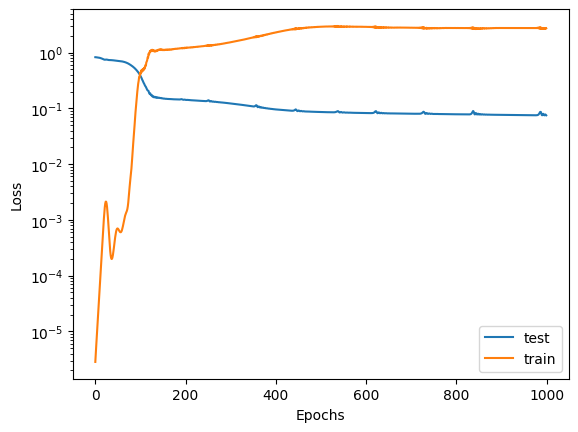

In [20]:
plt.figure()
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),test_loss)
plt.legend({'train','test'})
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

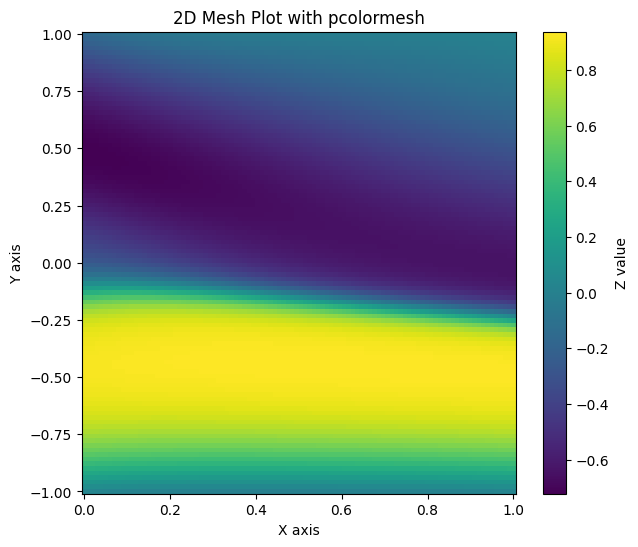

In [21]:
x = torch.linspace(-1,1,100)
t = torch.linspace(0,1,100)
X,T = torch.meshgrid(x,t,indexing='ij')
points=torch.stack([T.reshape(-1),X.reshape(-1)],dim=1)
Z = pinn(points)
Z = Z.reshape(100, 100)
plt.figure(figsize=(7, 6))
plt.pcolormesh(T.numpy(),X.numpy(), Z.detach().numpy(), cmap='viridis') #
plt.colorbar(label='Z value')
plt.title('2D Mesh Plot with pcolormesh')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

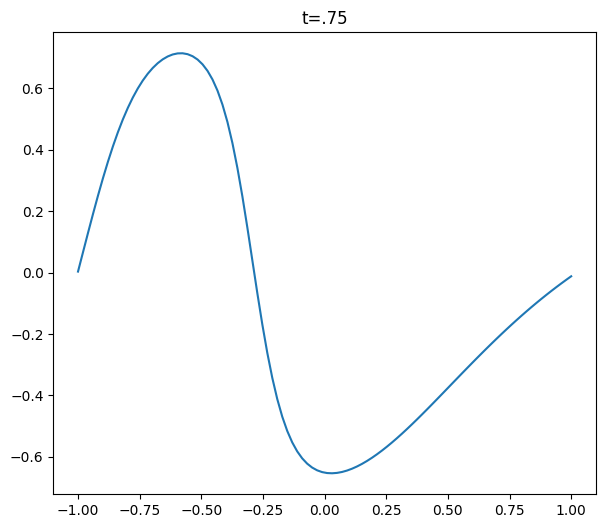

In [24]:
x = torch.linspace(-1,1,100)
t = torch.full_like(x,.75)
points = torch.stack([t,x],dim=1)
Z = pinn(points)
plt.figure(figsize=(7, 6))
plt.plot(x.numpy(), Z.detach().numpy()) #
plt.title('t=.75')
plt.show()